# GD (Guess and Determine) optimization 1, it takes few days to return the complete list of candidate states

A first optimization of the brute force attack is to apply the guess and determine attack (whose principle of operation has been explained earlier). We will first provide a naive recursive version.

Before implementing the algorithm that uses guess and determine to find the internal state of the register that generated the keystream, we first define a function (Mathematical theorem given earlier) that can recover the secret key K from an initial state of the register, uid, two nonce vectors iv1, iv2, and ks2.

In [15]:
from BruteForce import *
from IPython.display import Image
import itertools
import pickle
import zipfile
def try_recover(state, uid, iv1, iv2, ks2):
    """

    This function attempts to recover a key based on a candidate state, UID,a second keystream and two IV.
    It then tests this key against iv2 and ks2. If the key produces the correct keystream, it returns the key.
    
    """
    assert type(state)==type(uid)==type(iv1)==type(iv2)==type(ks2)==int,"state, uid, iv1, iv2 and ks2 must be integers"

    # Convert UID and state to binary strings and map each character to an integer
    state_int = list(map(int, f"{uid:032b}")) + list(map(int, f"{state:048b}"))[32:48][::-1] + list(map(int, f"{state:048b}"))[:32][::-1]
    
    # Extract a sublist of state_int containing bits from index 32 to 47
    key1 = state_int[32:48]
    
    # Iterate over the range [0, 32)
    for i in range(32):
        # Extract a sublist of state_int from index i to i+48 and reverse it
        a3 = state_int[i:48+i][::-1]
        
        # Calculate the XOR between state_int[i+48], iv1[i], and the integer value of a3 converted from binary
        key1.append(state_int[i+48] ^ int(f"{iv1:032b}"[i]) ^ f20(int(''.join(map(str, a3)), 2)))
    
    # Convert the list of bits in key1 to an integer
    key1 = int(''.join(str(bit) for bit in key1), 2)
    
    # Check if the keystream produced by iv2 matches ks2
    if ks2 == hitag2(hitag2_init(key1, uid, iv2)):
        return key1



To test the validity of this function, we can verify it using an example as follows.

In [16]:
key, uid, iv1, iv2 = 0x424f4247, 0x42424242, 0x43434343,0x43434344
state1 = hitag2_init(key, uid, iv1)
state2 = hitag2_init(key, uid, iv2)
ks1, ks2 = hitag2(state1,32), hitag2(state2,32)

#We check if it returns the correct key
try_recover(state1, uid, iv1, iv2, ks2)==key

True

As explained earlier, the attack is performed in 9 layers, and in each layer, the bits to guess can be represented as masks. The following figure indicates which bits are to be guessed in each layer.

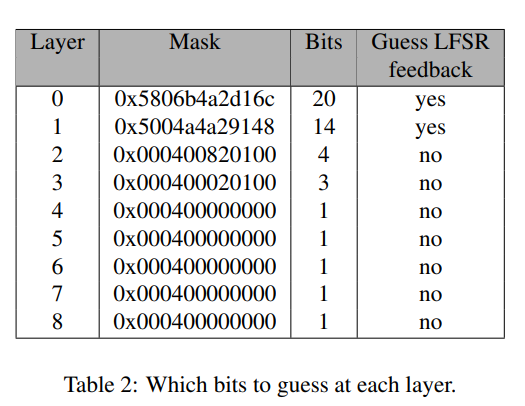

In [17]:
Image(filename='mask.png')

Now we can define the 9 masks and the number of bits to guess in each layer as follows:

In [18]:
masks=[96785823617388, 87980872208712, 17188389120, 17180000512, 17179869184, 17179869184, 17179869184, 17179869184, 17179869184] # Which bits to guess at each layer
bits=[20, 14, 4, 3, 1, 1, 1, 1, 1]# bits to guess in each layer

In the context of this attack, we will also need an "expand" function that distributes bits from a counter over the bits in a mask value.

In [19]:
def expand(mask, x):
    """
    Deposits bits from a counter `x` over the bits in a mask value `mask`.

    Parameters:
    - mask (int): The mask value representing which bits to deposit.
    - x (int): The counter value to deposit over the mask.

    Returns:
    - res (int): The resulting value after depositing bits over the mask.

    Algorithm:
    1. Initialize `res` to 0.
    2. Iterate over each bit position `i` from 0 to 47.
       - If the least significant bit of `mask` is 1:
         - Set the `i`-th bit of `res` to the least significant bit of `x`.
         - Right-shift `x` by 1 bit.
       - Right-shift `mask` by 1 bit.
    3. Return the resulting value `res`.
    """
    res = 0
    for i in range(0, 48):
        if mask & 1:
            res |= (x & 1) << i
            x >>= 1
        mask >>= 1
    return res

We will also need another function called "test" which is used to test the found state against the remaining 23 bits of the keystream

In [20]:
def test(state,keystream):
    """
    Tests the candidate state by comparing it to the remaining 23 bits of the secret key.
    Reverses the LFSR 32 times to return the initial state that generated the keystream.

    Args:
        state (int): Candidate state to test and the keystream.

    Returns:
        It returns either None or a list containing True and the list of candidate states

    """
    for bit in range(len(masks), 32):
        if f20(state) != keystream[bit]:
            return
        state = lfsr(state)
    for _ in range(32):
        state = lfsr_inv(state)
    return [True,state]

Now that we have defined all the necessary prerequisites, we can implement our attack using a recursive method.

In [22]:
def find_state1(keystream, state, layer, filt_mask=0x5806b4a2d16c):
    """
    Recursively finds the state that generated the keystream by iterating through layers.

    Args:
        keystream (list): List of observed keystream bits.
        state (int): Current state value which starts at 0
        layer (int): Current layer value which starts at 0
        filt_mask (int): Mask value for the layer's filter input bits.

    Returns:
        None

    """
    if layer < len(masks):
        # Iterate through the counter to determine the filter input bits for the layer
        for fill in range(0, 1 << bits[layer]):
            # Expand the counter value to the layer's mask using the expand function
            new_state = state | expand(masks[layer], fill)
            #print(new_state)
            # Check if the computed f20(new_state) matches the observed keystream bit for this layer
            if f20(new_state) != keystream[layer]:
                continue
            if layer < 2 : # 2 = Last LFSR guess
                # Iterate to the next layer with an updated LFSR feedback bit (0 and 1)
                find_state1(keystream, new_state >> 1, layer + 1, filt_mask)
                find_state1(keystream, (new_state >> 1) | (1 << 47), layer + 1, filt_mask)
            else:
                # Iterate to the next layer using the LFSR feedback of the computed state
                find_state1(keystream, lfsr(new_state), layer + 1, filt_mask)
    else:
        test(state)

To test the validity of this function, it is not recommended to execute it directly as it may take a long time. It is also not necessary to define a small-sized key as it will not reduce the complexity of the algorithm since it targets the internal state of the register rather than the key.

Instead, we can take the following example and modify our function by adding a condition that will help us avoid iterating over all possible combinations.

We start by defining our key, uid, iv, keystream and the filt_mask=0x5806b4a2d16c

In [23]:
key, uid, iv = 0x414141414141, 0x42424242, 0x43434343
state = hitag2_init(0x414141414141, 0x42424242, 0x43434343)
keystream_int = hitag2(state,32)
keystream = list(map(int, "{0:032b}".format(keystream_int)))

Next, we calculate the first 9 evolutions of the register

In [24]:
test_states = []
for _ in range(len(masks)):
    test_states.append(state)
    state = lfsr(state)

And now we re-implement our function by adding the condition: if (new_state & filt_mask) != (test_states[layer] & filt_mask) to check if the common bits (after applying a filter mask) between the guessed state and the real state are not different.

In [36]:
def find_state1_val(keystream, state, layer, filt_mask=0x5806b4a2d16c):
    """
    Recursively finds the state that generated the keystream by iterating through layers.

    Args:
        keystream (list): List of observed keystream bits.
        state (int): Current state value which starts at 0
        layer (int): Current layer value which starts at 0
        filt_mask (int): Mask value for the layer's filter input bits.

    Returns:
        None

    """
    if layer < len(masks):
        # Iterate through the counter to determine the filter input bits for the layer
        for fill in range(0, 1 << bits[layer]):
            # Expand the counter value to the layer's mask using the expand function
            new_state = state | expand(masks[layer], fill)
            #check if the common bits (after applying a filter mask) between the guessed state and the real state are not different.
            if (new_state & filt_mask) != (test_states[layer] & filt_mask):
                continue
            # Check if the computed f20(new_state) matches the observed keystream bit for this layer
            if f20(new_state) != keystream[layer]:
                continue
            if layer < 2 : # 2 = Last LFSR guess
                # Iterate to the next layer with an updated LFSR feedback bit (0 and 1)
                find_state1_val(keystream, new_state >> 1, layer + 1, filt_mask)
                find_state1_val(keystream, (new_state >> 1) | (1 << 47), layer + 1, filt_mask)
            else:
                # Iterate to the next layer using the LFSR feedback of the computed state
                find_state1_val(keystream, lfsr(new_state), layer + 1, filt_mask)
    else:
        print(test(state,keystream))

In [41]:
find_state1_val(keystream,0,0)

[True, 198129007952514]


We can see that the state returned by the algorithm is identical to the one we have already defined.

In [38]:
198129007952514== hitag2_init(0x414141414141, 0x42424242, 0x43434343)

True